In [200]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import tessreduce as tr

from scipy.optimize import minimize
from scipy import signal
from astropy.convolution import Gaussian2DKernel

from scipy.optimize import minimize

def Delta_basis(Size = 13):
    kernal = np.zeros((Size,Size))
    x,y = np.where(kernal==0)
    middle = int(len(x)/2)
    basis = []
    for i in range(len(x)):
        b = kernal.copy()
        if (x[i] == x[middle]) & (y[i] == y[middle]):
            b[x[i],y[i]] = 1
        else:
            b[x[i],y[i]] = 1
            b[x[middle],y[middle]] = -1
        basis += [b]
    basis = np.array(basis)
    coeff = np.ones(len(basis))
    return basis, coeff

In [174]:
ra = 189.1385817
dec = 11.2316535
#ra = 64.526125
#dec = -63.61506944
tpf = tr.Get_TESS(ra,dec)

mask = tr.Make_mask(tpf,)

bkg = tr.New_background(tpf,mask,)
flux = tpf.flux.value - bkg
ref = flux[100]
offset = tr.Centroids_DAO(flux,ref,TPF=tpf,parallel=False)

cor = tr.Shift_images(offset,flux)

exception calling callback for <Future at 0x7fc406e16ed0 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/rridden/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/Users/rridden/miniconda3/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/Users/rridden/miniconda3/lib/python3.7/site-packages/tessreduce/__init__.py", line 1, in <module>
    from .tessreduce import *
  File "/Users/rridden/miniconda3/lib/python3.7/site-packages/tessreduce/tessreduce.py", line 1391
    if tar_ap // 2 == tar_ap / 2:
                                ^
IndentationError: unindent does not match any outer indentation level
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call la

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [284]:
def Delta_kernal(Scene,Image,Size=13):
    Basis, coeff_0 = Delta_basis(Size)
    bds = []
    for i in range(len(coeff_0)):
        bds += [(0,1)]
    coeff_0 *= 0.01
    res = minimize(optimize_delta, coeff_0, args=(Basis,Scene,Image),
                   bounds=bds)
    k = np.nansum(res.x[:,np.newaxis,np.newaxis]*Basis,axis=0)
    return k
        
def optimize_delta(Coeff, Basis, Scene, Image):
    Kernal = np.nansum(Coeff[:,np.newaxis,np.newaxis]*Basis,axis=0)

    template = signal.fftconvolve(Scene, Kernal, mode='same')
    
    im = Image.copy()
    
    res = np.nansum(abs(im-template))
    #print(res)
    return res
    
    

In [285]:
thing = Delta_kernal(cor[100],cor[1200],Size=7)

In [293]:
def Make_temps(image, ref,size=7):
    k = Delta_kernal(ref,image,Size=size)
    template = signal.fftconvolve(ref, k, mode='same')
    return template

In [291]:
ref = cor[100]
temps = np.zeros_like(cor)
for i in range(cor.shape[0]):
    k = Delta_kernal(ref,cor[i],Size=7)
    template = signal.fftconvolve(ref, k, mode='same')
    print(i)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


KeyboardInterrupt: 

In [340]:
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
num_cores = multiprocessing.cpu_count()
tmps = Parallel(n_jobs=num_cores)(delayed(Make_temps)(flux[i],ref) for i in tqdm(range(cor.shape[0])))
    
    

100%|██████████| 1235/1235 [07:33<00:00,  2.72it/s]


In [341]:
templates = np.array(tmps)

In [300]:
templates.shape

(1235, 90, 90)

In [302]:
sub = cor - templates
sub2 = f - templates

In [336]:
#lc1, sky1 = tr.diff_lc(sub,tpf=tpf,ra=ra,dec=dec,tar_ap=3,sky_in=3,sky_out=5)
lc1, sky1 = tr.diff_lc(cor,tpf=tpf,ra=ra,dec=dec)
lc2, sky2 = tr.diff_lc(cor,tpf=tpf,x=45,y=50)

/Users/rridden/miniconda3/lib/python3.7/site-packages/tessreduce/tessreduce.py:1423: LightkurveDeprecationWarning: The astropy_time function is deprecated and may be removed in a future version.
        Use time instead.
  tar = np.nansum(diff*ap_tar,axis=(1,2))


<IPython.core.display.Javascript object>


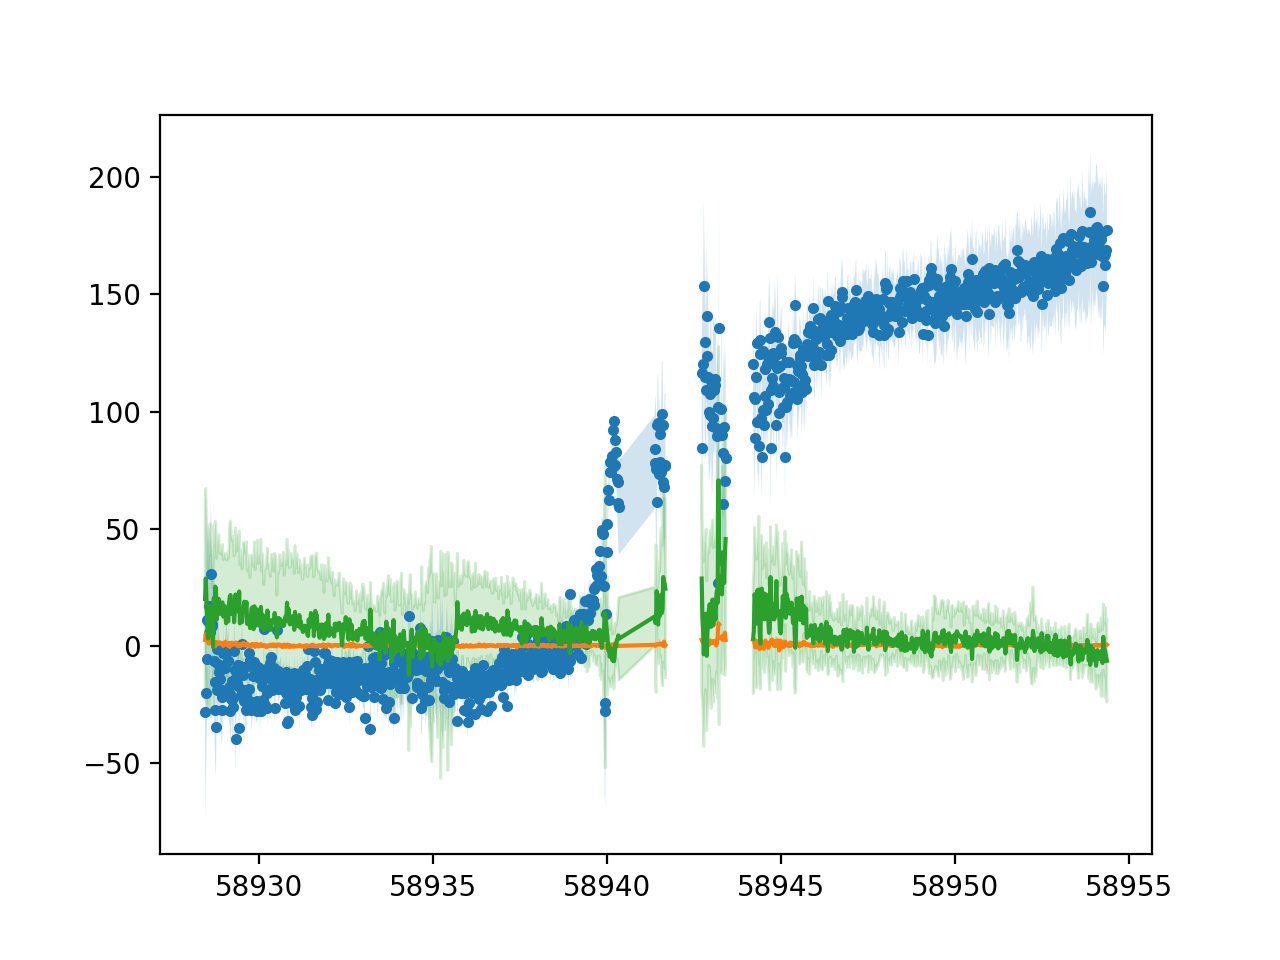

In [339]:
lc1[1] = lc1[1] - lc2[1]
plt.figure()
plt.fill_between(lc1[0],lc1[1]-lc1[2],lc1[1]+lc1[2],alpha=0.2)
plt.plot(lc1[0],lc1[1],'.')
plt.plot(sky1[0],sky1[1])

plt.fill_between(lc2[0],lc2[1]-lc2[2],lc2[1]+lc2[2],alpha=0.2,color='C2')
plt.plot(lc2[0],lc2[1],'C2')

<IPython.core.display.Javascript object>


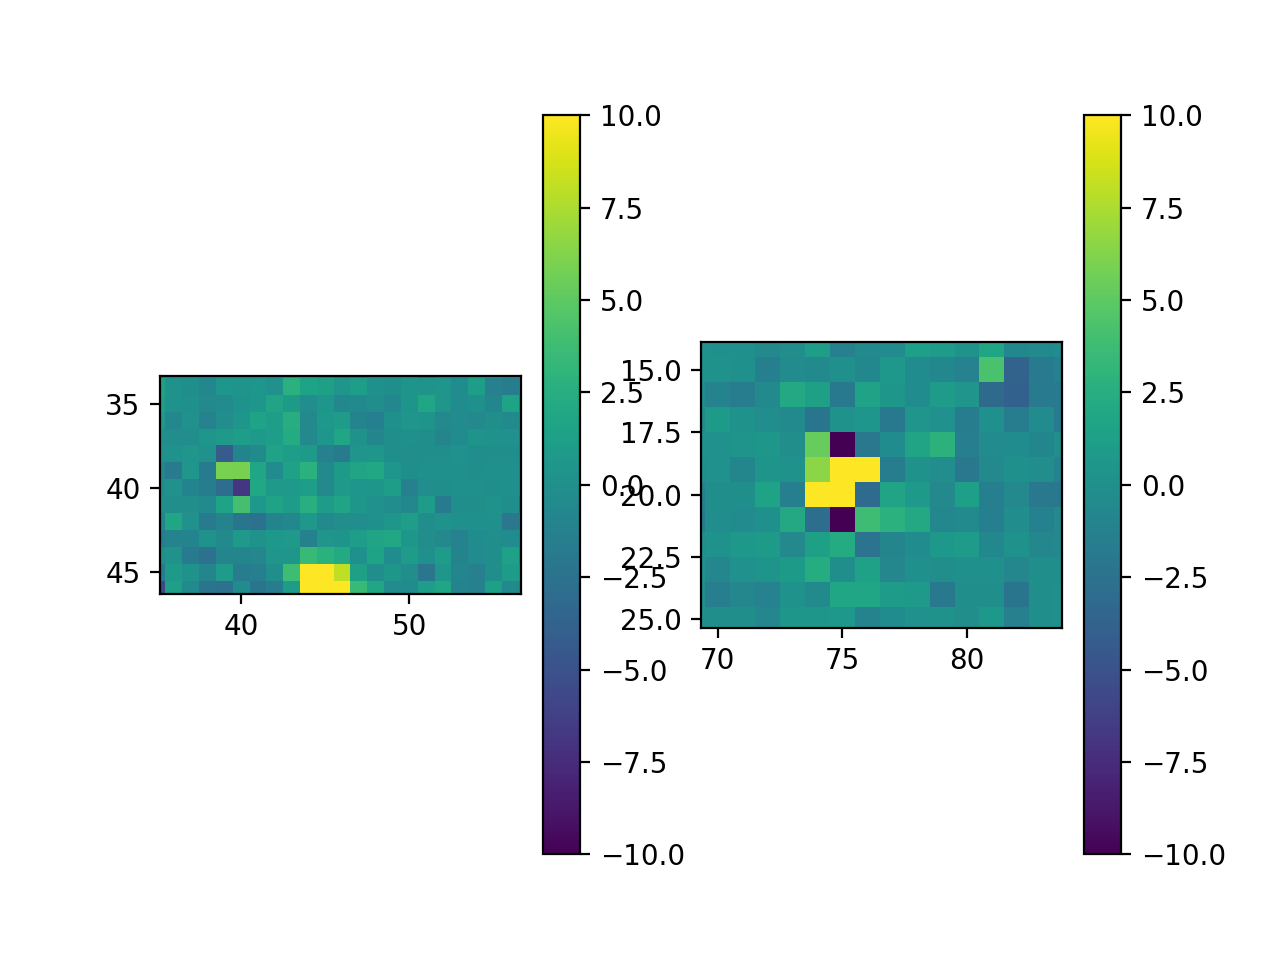

In [329]:
plt.figure()
plt.subplot(121)
plt.imshow(cor[1000]-ref,vmin=-10,vmax=10)
plt.colorbar()

plt.subplot(122)
plt.imshow(sub[1000],vmin=-10,vmax=10)
plt.colorbar()

In [266]:
test = np.zeros_like(cor[100])
test[45,45] = 1000
test = cor[100]
basis, coeff_0 = Delta_basis(7)
bds = []
for i in range(len(coeff_0)):
    bds += [(0,1)]
coeff_0 *= 0.01
res = minimize(optimize_delta, coeff_0, args=(basis,test,cor[1200]),bounds=bds)

In [267]:
res

      fun: 28593.7238408318
 hess_inv: <49x49 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 75540.83495052,  59841.74931655,  -1022.85048342,  15168.45622973,
       103427.63562221, 163714.92820326, 141696.15606079, 123573.095334  ,
       137198.57233809, 103442.49676564, 116821.70661516, 162602.86865872,
       166564.79092489,  89171.49243644,  88859.10428944,  87561.48818065,
         5001.80685779,   -398.15640769,  75488.99739049, 127685.56152878,
        40927.51005373,  48383.51524086,  19461.72633325,   1073.16373033,
         -779.27506545,   -521.37620515,  28704.90679925,  23290.83654331,
        59399.54135101,  88854.98500604,  54469.64642033,   2842.07417233,
        79390.41825011, 126001.68738572,  73005.60828298,  75953.47160532,
       163061.36130879, 172667.17040911, 140406.52968106, 178185.48330979,
       166449.42988933, 132111.61276558, 114586.14426374, 163762.64720748,
       126814.98119491,  64235.20098906, 154024.33018608, 215945.8505048 ,
   

In [244]:
from scipy.signal import convolve

In [268]:
k = np.nansum(res.x[:,np.newaxis,np.newaxis]*basis,axis=0)
template = signal.fftconvolve(test, k, mode='same')

In [269]:
np.sum(Kernel)

1.0070876920910152

<IPython.core.display.Javascript object>


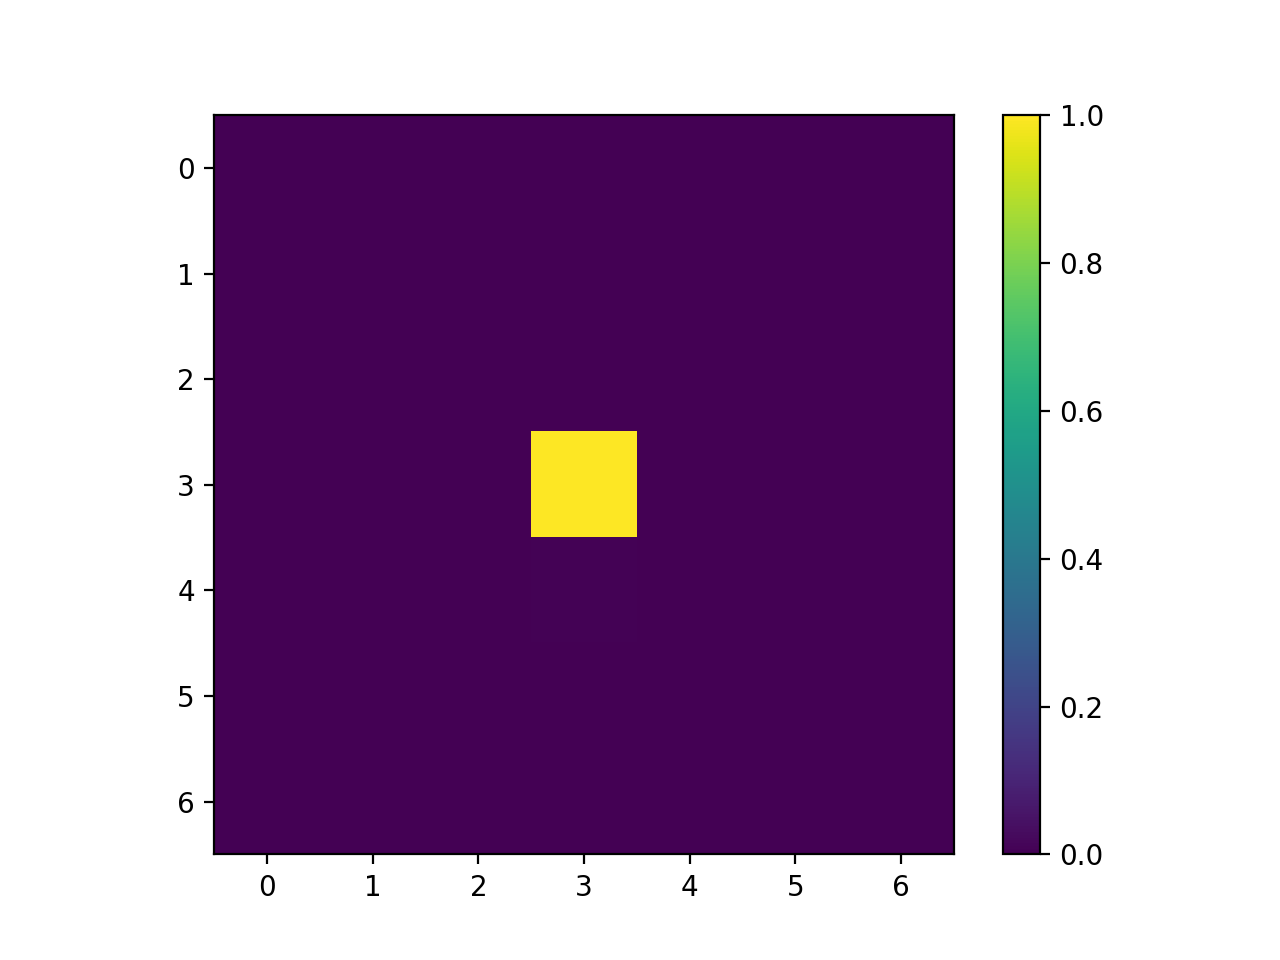

In [270]:
plt.figure()
plt.imshow(Kernel)
plt.colorbar()

In [271]:
np.nansum(template)


345993.441668765

In [272]:
np.nansum(test)

346331.7253642712

<IPython.core.display.Javascript object>


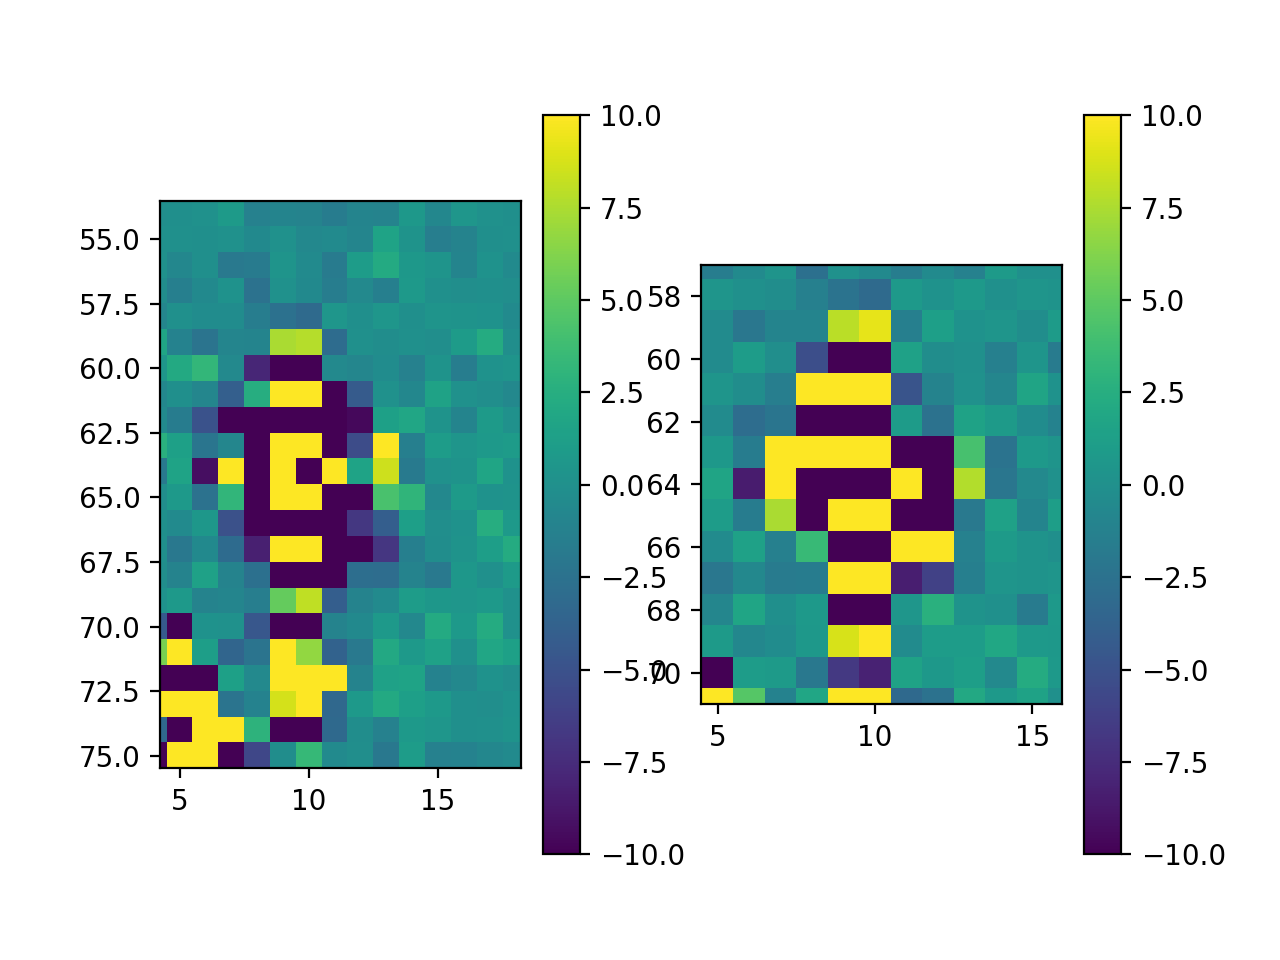

In [275]:
plt.figure()
plt.subplot(121)
plt.imshow(cor[1000]-template,vmin=-10,vmax=10)
plt.colorbar()

plt.subplot(122)
plt.imshow(cor[1000]-cor[100],vmin=-10,vmax=10)
plt.colorbar()

In [134]:
im = cor[1000].copy()
template = signal.fftconvolve(cor[100], Kernel, mode='same')
im[im< 10] = np.nan
res = np.nansum(abs(np.log10(im - np.log10(template))))

<IPython.core.display.Javascript object>


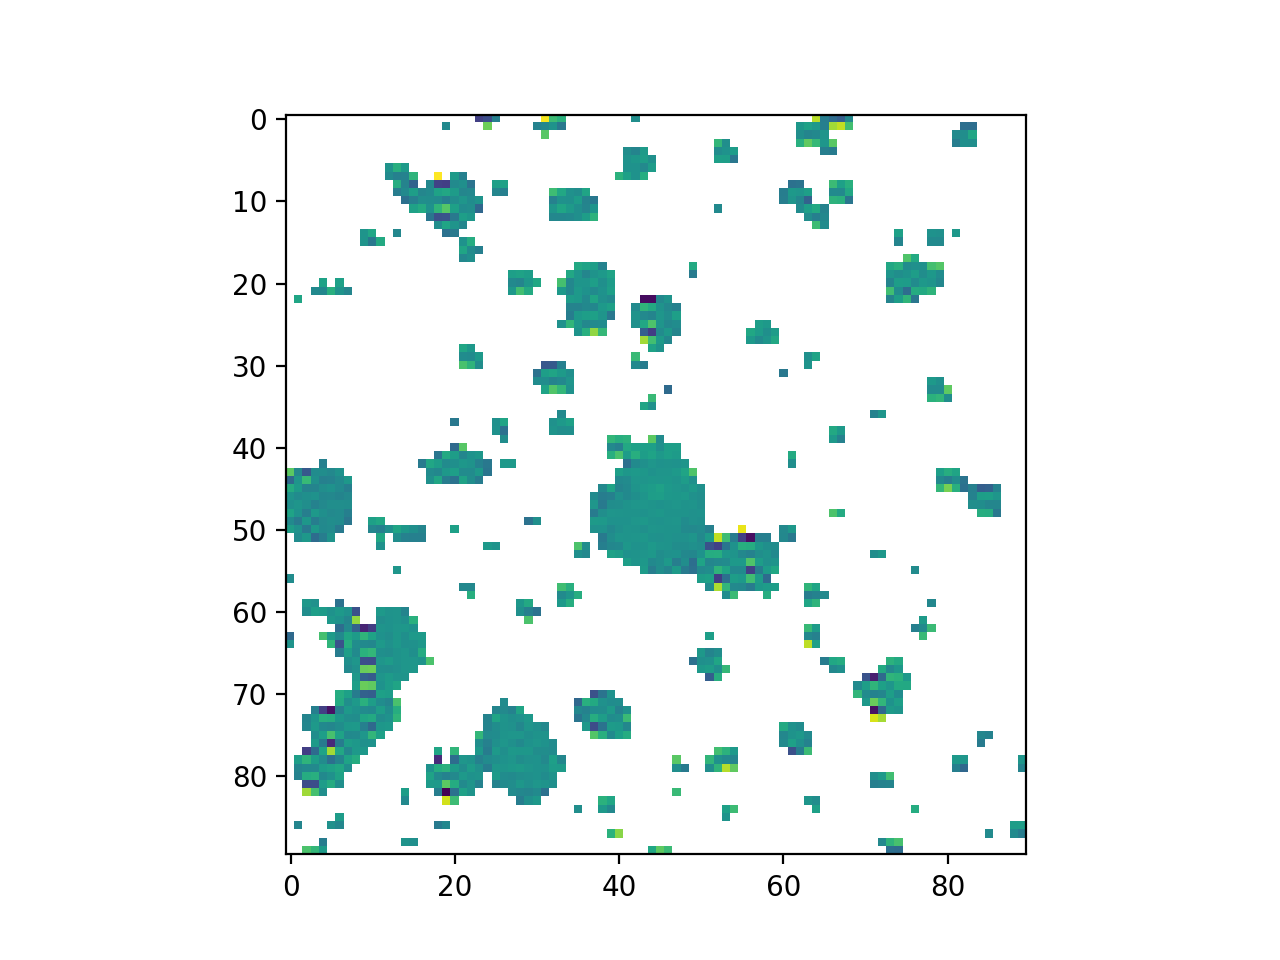

In [151]:
a = im/cor[100]-1
m = sigma_clip(a,sigma=5).mask
a[m] = np.nan

plt.figure()
plt.imshow(a)

In [144]:
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True]])

In [152]:
np.nansum(a)

-2.784360905651944

In [141]:
sigma_clip(im/cor[100]-1)

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, -0.04394740096840799, -0.10340481678647295],
        [--, --, --, ..., --, --, --],
        [--, --, 0.2212019122834521, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True, False, False],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True]],
  fill_value=1e+20)

In [140]:
from astropy.stats import sigma_clip